# Импорт

In [1]:
import os.path as path_

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from lightgbm import Dataset, train, cv, plot_importance

# Глобальные переменные и функции

In [3]:
data_path = 'data'
submit_path = 'submits'
seed = 110894

# Загружаем данные

## Словарь

In [4]:
df_sku_dict = pd.read_csv(path_.join(data_path, 'sku_dict.csv'))
df_sku_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sku_id           10000 non-null  int64 
 1   fincode          10000 non-null  object
 2   ui1_code         10000 non-null  object
 3   ui2_code         10000 non-null  object
 4   ui3_code         10000 non-null  object
 5   vendor           10000 non-null  object
 6   brand_code       10000 non-null  object
 7   creation_date    10000 non-null  object
 8   expiration_date  10000 non-null  object
dtypes: int64(1), object(8)
memory usage: 703.2+ KB


In [5]:
df_sku_dict['creation_date'] = pd.to_datetime(df_sku_dict['creation_date'])
df_sku_dict['expiration_date'] = pd.to_datetime(df_sku_dict['expiration_date'])

## Группы

In [6]:
df_first_group_sku = pd.read_csv(path_.join(data_path, 'first_group_sku.csv'))
df_first_group_sku.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dates          245 non-null    object 
 1   SKU            245 non-null    int64  
 2   price_per_sku  169 non-null    float64
 3   num_purchases  245 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 7.8+ KB


In [7]:
df_second_group_sku = pd.read_csv(path_.join(data_path, 'second_group_sku.csv'))
df_second_group_sku.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3749 entries, 0 to 3748
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dates          3749 non-null   object 
 1   SKU            3749 non-null   int64  
 2   price_per_sku  3749 non-null   float64
 3   num_purchases  3749 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 117.3+ KB


In [8]:
df_third_group_sku = pd.read_csv(path_.join(data_path, 'third_group_sku.csv'))
df_third_group_sku.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2781 entries, 0 to 2780
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dates          2781 non-null   object 
 1   SKU            2781 non-null   int64  
 2   price_per_sku  2781 non-null   float64
 3   num_purchases  2781 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 87.0+ KB


In [9]:
df_concated = pd.concat(
    [
        df_first_group_sku.assign(group='first'),
        df_second_group_sku.assign(group='second'),
        df_third_group_sku.assign(group='third'),
    ],
    ignore_index=True,
)
df_concated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6775 entries, 0 to 6774
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dates          6775 non-null   object 
 1   SKU            6775 non-null   int64  
 2   price_per_sku  6699 non-null   float64
 3   num_purchases  6775 non-null   int64  
 4   group          6775 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 264.8+ KB


In [10]:
df_concated['dates'] = pd.to_datetime(df_concated['dates'])

In [11]:
del df_first_group_sku, df_second_group_sku, df_third_group_sku

In [12]:
df_concated['group'].value_counts()

second    3749
third     2781
first      245
Name: group, dtype: int64

## Промо

In [13]:
df_promo = pd.read_csv(path_.join(data_path, 'promo_1510002.csv'))
df_promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      52 non-null     int64  
 1   week_num  52 non-null     int64  
 2   SKU       52 non-null     int64  
 3   discount  52 non-null     float64
dtypes: float64(1), int64(3)
memory usage: 1.8 KB


## Конкуренты

In [14]:
df_conc = pd.read_csv(path_.join(data_path, 'conc_df.csv'))
df_conc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3009 entries, 0 to 3008
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SKU            3009 non-null   int64  
 1   year           3009 non-null   int64  
 2   week_num       3009 non-null   int64  
 3   ret_net_code   3009 non-null   int64  
 4   price_per_sku  3009 non-null   float64
dtypes: float64(1), int64(4)
memory usage: 117.7 KB


## Тест

In [15]:
df_test = pd.read_csv(path_.join(data_path, 'test.csv'))
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dates   175 non-null    object
 1   SKU     175 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ KB


In [16]:
df_test['dates'] = pd.to_datetime(df_test['dates'])

# EDA

In [17]:
df_concated['dates'].min(), df_concated['dates'].max()

(Timestamp('2018-01-17 00:00:00'), Timestamp('2019-12-24 00:00:00'))

In [18]:
df_test['dates'].min(), df_test['dates'].max()

(Timestamp('2018-12-17 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [19]:
df_concated['SKU'].nunique() == df_test['SKU'].nunique()

True

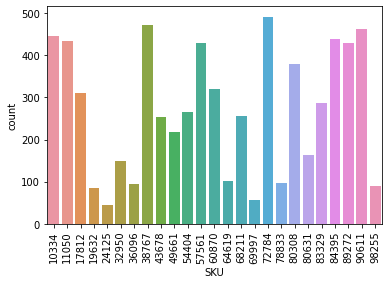

In [20]:
sns.countplot(x='SKU', data=df_concated)
_ = plt.xticks(rotation=90)

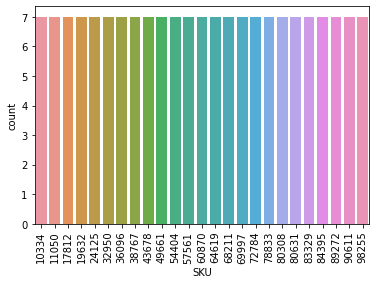

In [21]:
sns.countplot(x='SKU', data=df_test)
_ = plt.xticks(rotation=90)

In [22]:
(
    df_concated
    .groupby('SKU')
    .agg(
        max_diff=('dates', lambda x: x.sort_values().diff().dt.days.max()),
        med_diff=('dates', lambda x: x.sort_values().diff().dt.days.median()),
    )
    .sort_values('max_diff', ascending=False)
    .head(5)
)

,max_diff,med_diff
SKU,,
78833,21.0,3.0
32950,10.0,2.0
49661,10.0,1.0
36096,7.0,1.0
98255,6.0,1.0


In [23]:
(
    df_test
    .groupby('SKU')
    .agg(
        max_diff=('dates', lambda x: x.sort_values().diff().dt.days.max()),
        med_diff=('dates', lambda x: x.sort_values().diff().dt.days.median()),
    )
    .sort_values('max_diff', ascending=False)
    .head(5)
)

,max_diff,med_diff
SKU,,
98255,4.0,1.0
69997,4.0,2.0
43678,4.0,1.5
57561,4.0,2.0
78833,4.0,1.5


In [24]:
(df_test.groupby('SKU')['dates'].min() - df_concated.groupby('SKU')['dates'].max()).sort_values().tail(5)

SKU
24125    2 days
11050    2 days
80308    3 days
17812    3 days
78833   14 days
Name: dates, dtype: timedelta64[ns]

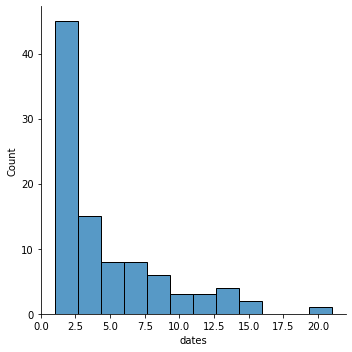

In [25]:
sns.displot(df_concated[df_concated['SKU'] == 78833]['dates'].diff().dt.days)

In [26]:
df_promo['year'].max(), df_test['dates'].dt.year.max()

(2019, 2019)

In [27]:
(
    df_promo[df_promo['year'] == 2019]['week_num'].max(),
    df_test[df_test['dates'].dt.year == 2019]['dates'].dt.week.max(),
)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(52, 52)

In [28]:
df_conc['year'].max(), df_test['dates'].dt.year.max()

(2019, 2019)

In [29]:
(
    df_conc[df_conc['year'] == 2019]['week_num'].max(),
    df_test[df_test['dates'].dt.year == 2019]['dates'].dt.week.max(),
)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(52, 52)

In [30]:
df_sku_dict['ui1_code'].nunique()

46

In [31]:
df_sku_dict['sku_id'].nunique()

10000

In [32]:
len(set(df_sku_dict['sku_id'].unique()).intersection(set(df_concated['SKU'].unique())))

25

In [33]:
df_sku_dict['ui2_code'].nunique()

109

In [34]:
df_sku_dict['ui3_code'].nunique()

804

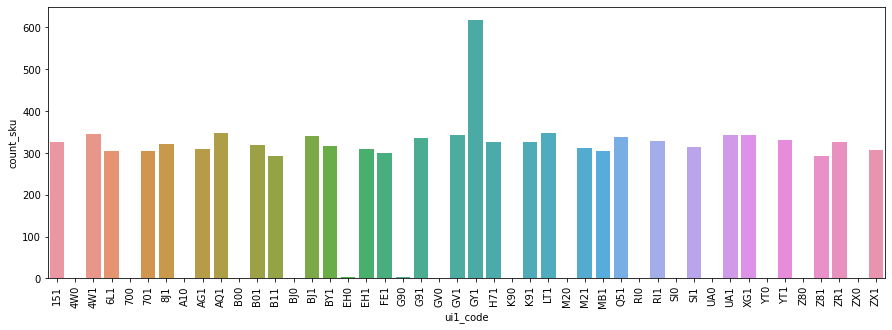

In [35]:
df_ui_grouped = ( 
    df_sku_dict
    .groupby('ui1_code', as_index=False)
    .agg(count_sku=('sku_id', lambda x: x.nunique()))
)
_ = plt.figure(figsize=(15, 5))
sns.barplot(x='ui1_code', y='count_sku', data=df_ui_grouped)
_ = plt.xticks(rotation=90)

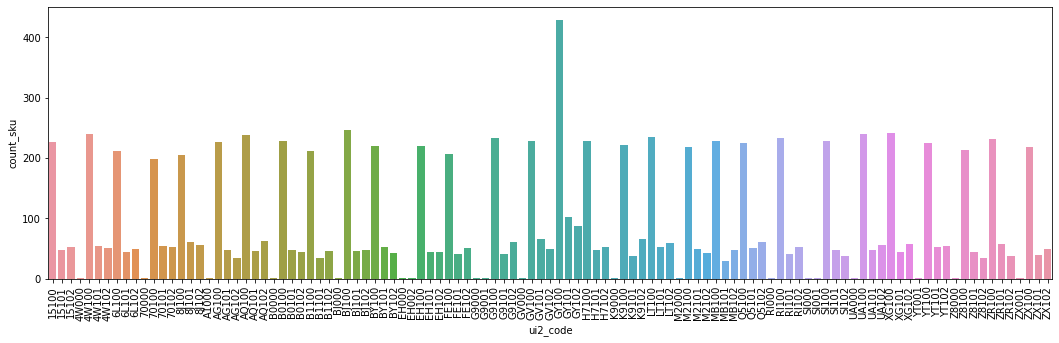

In [36]:
df_ui_grouped = ( 
    df_sku_dict
    .groupby('ui2_code', as_index=False)
    .agg(count_sku=('sku_id', lambda x: x.nunique()))
    .assign(ui1_code=lambda X: X['ui2_code'].str[:3])
    .sort_values('ui2_code')
)
_ = plt.figure(figsize=(18, 5))
sns.barplot(x='ui2_code', y='count_sku', data=df_ui_grouped)
_ = plt.xticks(rotation=90)

In [37]:
df_sku_dict['vendor'].nunique(), df_sku_dict['vendor'].unique()

(25,
 array(['A10001', 'BLW9FG', '7I77VL', '4HJSP5', 'JSOSD5', 'VWHZMG',
        '2CI2A8', 'GVL335', 'SJP384', 'LDLJFP', 'B4TA32', 'FI3ASO',
        'SHL570', '71SM2O', 'TJYT3A', 'UEYMBB', 'T9BUA7', 'H2OK0Z',
        'AWD3XQ', 'CHQKSO', 'AO59EQ', '3GFIMK', 'UH2WWF', '4O4WSH',
        'VZ44WY'], dtype=object))

In [38]:
df_sku_dict['brand_code'].nunique(), df_sku_dict['brand_code'].unique()

(63,
 array(['A1000001', '484JDFU5', 'MMC2P4Y3', '8FYENEWM', 'YTE7JS4H',
        'O0Q22TYD', '1VPSWMTF', '52JETVXH', 'FJMH9IG1', '4LU3GS87',
        'Z7FUX49S', '5XUYK688', 'HDHOCYPD', 'KU7Q9EM1', 'UEKGPFHF',
        'O8WJHL4Q', 'F87SIC0N', 'LNOTDGF7', '3P2I0S6S', 'THSTSG81',
        '4WL34OA2', '9XGMSC3X', 'VMB2NPY2', '8QJHUA65', '38HT8FNL',
        'J8XKU94W', '9J3MMTSQ', '8TMVJREA', '25T5WNRI', 'WKXRWTP7',
        'H0PQ4U24', '5QQF7PWJ', 'YZ7ES5HU', 'XF98E5PI', 'R36KIEMV',
        '5IEJMU4O', 'UWKPEFCJ', '6VU0IOUP', '1F5HYT5P', 'M2LFH9WE',
        '3FAIRJ4W', '2XSAI69H', 'W581KQD3', '4P277OU8', 'JXS1Z5D7',
        'H01VAI1S', 'G6OB30M4', '02Q78ADY', 'VCZNKWIS', 'SKXXW8V9',
        'UJWSTGEH', '72PNE8FJ', '20SL2XLU', 'Z4ZXJ8UY', 'GS4NPH2K',
        'N2CAIPJF', 'JK4UKBI2', '28V0149U', 'AXB8H17D', 'Q6NGRHUA',
        '79VL731U', '74CKJ9XQ', 'H1BWFJRN'], dtype=object))

# Готовим данные

In [39]:
df_whole = pd.concat(
    [
        df_concated.assign(sample='train'),
        df_test.assign(sample='test'),
    ],
    ignore_index=True,
)
df_whole = df_whole.sort_values(['SKU', 'price_per_sku'])
df_whole.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6950 entries, 583 to 6781
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dates          6950 non-null   datetime64[ns]
 1   SKU            6950 non-null   int64         
 2   price_per_sku  6699 non-null   float64       
 3   num_purchases  6775 non-null   float64       
 4   group          6775 non-null   object        
 5   sample         6950 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 380.1+ KB


In [40]:
mask = df_whole['sample'] == 'train'
df_whole.loc[mask, 'price_per_sku'] = df_whole.loc[mask, 'price_per_sku'].fillna(method='ffill')

In [41]:
df_whole.loc[mask, 'price_per_sku'].isna().sum()

0

In [42]:
for n_lag in range(1, 12):
    df_whole[f'lag_{n_lag}_price_per_sku'] = df_whole.groupby('SKU')['price_per_sku'].shift(n_lag)
df_whole.head()

,dates,SKU,price_per_sku,num_purchases,group,sample,lag_1_price_per_sku,lag_2_price_per_sku,lag_3_price_per_sku,lag_4_price_per_sku,lag_5_price_per_sku,lag_6_price_per_sku,lag_7_price_per_sku,lag_8_price_per_sku,lag_9_price_per_sku,lag_10_price_per_sku,lag_11_price_per_sku
583,2019-07-22,10334,79.1504,14.0,second,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
584,2019-07-23,10334,79.1504,12.0,second,train,79.1504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585,2019-07-24,10334,79.1504,14.0,second,train,79.1504,79.1504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
586,2019-07-25,10334,79.1504,12.0,second,train,79.1504,79.1504,79.1504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
587,2019-07-28,10334,79.1504,15.0,second,train,79.1504,79.1504,79.1504,79.1504,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
df_whole[df_whole['SKU'] == 10334].head()

,dates,SKU,price_per_sku,num_purchases,group,sample,lag_1_price_per_sku,lag_2_price_per_sku,lag_3_price_per_sku,lag_4_price_per_sku,lag_5_price_per_sku,lag_6_price_per_sku,lag_7_price_per_sku,lag_8_price_per_sku,lag_9_price_per_sku,lag_10_price_per_sku,lag_11_price_per_sku
583,2019-07-22,10334,79.1504,14.0,second,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
584,2019-07-23,10334,79.1504,12.0,second,train,79.1504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585,2019-07-24,10334,79.1504,14.0,second,train,79.1504,79.1504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
586,2019-07-25,10334,79.1504,12.0,second,train,79.1504,79.1504,79.1504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
587,2019-07-28,10334,79.1504,15.0,second,train,79.1504,79.1504,79.1504,79.1504,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
df_whole[df_whole['SKU'] == 10334].tail(7)

,dates,SKU,price_per_sku,num_purchases,group,sample,lag_1_price_per_sku,lag_2_price_per_sku,lag_3_price_per_sku,lag_4_price_per_sku,lag_5_price_per_sku,lag_6_price_per_sku,lag_7_price_per_sku,lag_8_price_per_sku,lag_9_price_per_sku,lag_10_price_per_sku,lag_11_price_per_sku
6864,2019-12-25,10334,NaN,NaN,NaN,test,102.781,102.781,102.781,102.781,102.214,102.214,102.214,102.214,101.976,101.976,101.976
6871,2019-12-26,10334,NaN,NaN,NaN,test,NaN,102.781,102.781,102.781,102.781,102.214,102.214,102.214,102.214,101.976,101.976
6894,2019-12-27,10334,NaN,NaN,NaN,test,NaN,NaN,102.781,102.781,102.781,102.781,102.214,102.214,102.214,102.214,101.976
6905,2019-12-28,10334,NaN,NaN,NaN,test,NaN,NaN,NaN,102.781,102.781,102.781,102.781,102.214,102.214,102.214,102.214
6916,2019-12-29,10334,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN,102.781,102.781,102.781,102.781,102.214,102.214,102.214
6929,2019-12-30,10334,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN,NaN,102.781,102.781,102.781,102.781,102.214,102.214
6943,2019-12-31,10334,NaN,NaN,NaN,test,NaN,NaN,NaN,NaN,NaN,NaN,102.781,102.781,102.781,102.781,102.214


In [45]:
ss_mapping = (
    df_whole
    .groupby('SKU')
    .agg(map_=('group', lambda x: list(x.unique())[0]))
    .loc[:, 'map_']
)
ss_mapping.head()

SKU
10334    second
11050     third
17812    second
19632     third
24125     third
Name: map_, dtype: object

In [46]:
mask = df_whole['sample'] == 'test'
df_whole.loc[mask, 'group'] = df_whole.loc[mask, 'SKU'].map(ss_mapping)
df_whole.loc[mask, 'group'].value_counts(dropna=False)

second    91
third     70
first     14
Name: group, dtype: int64

In [47]:
df_whole['SKU'] = df_whole['SKU'].astype('category')
df_whole['group'] = df_whole['group'].astype('category')
df_whole['sample'] = df_whole['sample'].astype('category')

# Строим бэйзлайн

In [48]:
list_drop_columns = [
    'dates',
    'SKU',
    'price_per_sku',
    'num_purchases',
    'group',
    'sample',
]
mask = df_whole['sample'] == 'train'
X = df_whole.loc[mask, :].drop(columns=list_drop_columns)
y = df_whole.loc[mask, 'price_per_sku']
X.shape

(6775, 11)

In [49]:
ss_q_for_split = (
    df_whole
    .groupby('SKU')
    .agg(q=('dates', lambda x: x.quantile(0.70)))
    .loc[:, 'q']
)
df_whole['q_for_split'] = df_whole['SKU'].map(ss_q_for_split)
df_whole.head()

,dates,SKU,price_per_sku,num_purchases,group,sample,lag_1_price_per_sku,lag_2_price_per_sku,lag_3_price_per_sku,lag_4_price_per_sku,lag_5_price_per_sku,lag_6_price_per_sku,lag_7_price_per_sku,lag_8_price_per_sku,lag_9_price_per_sku,lag_10_price_per_sku,lag_11_price_per_sku,q_for_split
583,2019-07-22,10334,79.1504,14.0,second,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-24 19:12:00
584,2019-07-23,10334,79.1504,12.0,second,train,79.1504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-24 19:12:00
585,2019-07-24,10334,79.1504,14.0,second,train,79.1504,79.1504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-24 19:12:00
586,2019-07-25,10334,79.1504,12.0,second,train,79.1504,79.1504,79.1504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-24 19:12:00
587,2019-07-28,10334,79.1504,15.0,second,train,79.1504,79.1504,79.1504,79.1504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-24 19:12:00


In [50]:
mask = df_whole['dates'] <= df_whole['q_for_split']
X_train, y_train = X.loc[mask, :], y[mask]
X_valid, y_valid = X.loc[~mask, :], y[~mask]
X_train.shape, X_valid.shape

((4860, 11), (1915, 11))

In [51]:
del df_whole['q_for_split']

In [52]:
lgb_train = Dataset(X_train, y_train)
lgb_valid = Dataset(X_valid, y_valid, reference=lgb_train)
lgb_model = train(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'seed': seed,
        'verbosity': -1,
    },
    train_set=lgb_train,
    num_boost_round=100_000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train', 'valid'],
    early_stopping_rounds=100,
    verbose_eval=100,
)

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.43125	valid's rmse: 5.474
[200]	train's rmse: 5.3616	valid's rmse: 3.77325
[300]	train's rmse: 5.33948	valid's rmse: 3.43559
[400]	train's rmse: 5.33334	valid's rmse: 3.3986
Early stopping, best iteration is:
[370]	train's rmse: 5.33468	valid's rmse: 3.39436


In [53]:
def predict_one_model(data, model):
    data_ = data.copy()
    for i in range(7):
        mask = (
            (data_['sample'] == 'test')
            & data_['lag_1_price_per_sku'].notna()
        )
        X_test = data_.loc[mask, :].drop(columns=list_drop_columns)
        data_.loc[mask, 'price_per_sku'] = lgb_model.predict(X_test)
        for n_lag in range(1, 12):
            data_[f'lag_{n_lag}_price_per_sku'] = data_.groupby('SKU')['price_per_sku'].shift(n_lag)
    return data_.loc[data_['sample'] == 'test', ['dates', 'SKU', 'price_per_sku']]

In [56]:
df_predict = predict_one_model(df_whole, lgb_model)
assert df_predict['price_per_sku'].isna().sum() == 0
assert df_predict.shape[0] == df_test.shape[0]
df_predict.head()

,dates,SKU,price_per_sku
6864,2019-12-25,10334,102.612128
6871,2019-12-26,10334,102.627619
6894,2019-12-27,10334,102.793488
6905,2019-12-28,10334,102.793488
6916,2019-12-29,10334,102.793488


In [57]:
df_predict.to_csv(path_.join(submit_path, 'prediction_baseline.csv'), index=False)